# 美联储净流动性

资金流动性是影响风险资产价格的关键因素，影响流动性的两个重要因素是财政政策和货币政策。

计算净流动性的公式：

$$Net Liquidity = Fed Balance Sheet - Reverse Repo - Treasury General Account$$

- `Fed Balance Sheet`：美联储资产负债表
- `Reverse Repo`：逆回购
- `Treasury General Account`：美国财政部账户

### TGA余额

TGA（Treasury General Account，财政部一般账号），美国政府（财政部）在美联储的存款账号。TGA余额的变化通常被视为美国政府对市场流动性的影响。TGA余额的减少意味着美国政府向市场注入流动性，TGA余额的增加则意味着从市场回收流动性。

**数据来源**

- [财政部官网](https://fiscaldata.treasury.gov/datasets/daily-treasury-statement/operating-cash-balance)
- [MacroMicro](https://en.macromicro.me/collections/9/us-market-relative/34339/us-treasury-general-account)

**Operating Cash Balance**

- 财政部提供了多个数据集来记录资金使用情况，其中`Operating Cash Balance`数据集记录了美国财政部每日的一般账号余额，单位为百万美元。
- 数据集包含了从2005年1月3日至今的数据。
- 数据集包含一个字段`account_type`，在不同的时间段用不同的账户来表示账户余额，详情如下：
    - 2005年至2021年9月30号：`account_type='Federal Reserve Account'`表示账户余额
    - 2021年10月1号至2022年4月15号：`account_type='Treasury General Account (TGA)'`表示账户余额
    - 2022年4月18号至今：`account_type='Treasury General Account (TGA) Closing Balance'`表示账户余额

### 美联储资产负债表

美联储资产负债表：美联储持有的资产。

- QE：美联储购买国债和MBS，向银行体系注入储备金，银行增加信贷，向市场注入流动性，部分资金可能进入金融市场并推动风险资产价格上涨。
- QT：美联储出售持有资产，从金融市场回收流动性，通常导致利率上升和风险资产价格下跌。

### 逆回购

逆回购：Reverse Repurchase Agreement(RRP)，也简称为Reverse Repo。

逆回购是美联储重要的货币政策工具，主要用于影响市场流动性和短期利率，机制如下：

- 美联储向市场参与者（货币市场基金，商业银行等）暂时借入资金（回收流动性）
- 用国债等资产作为抵押品
- 约定未来时点归还本金和利息（释放流动性）

当逆回购余额增加时，意味着美联储正在回收流动性，相当于临时QT，当逆回购余额减少时，意味着美联储正在向市场注入流动性，相当于临时QE。

### 其它流动性指标

Bank Term Funding Program (BTFP) 是美联储在2023年3月推出的银行融资计划：

- 为银行提供最长1年期贷款
- 接受合格债券作为抵押品
- 抵押品按面值估值
- 旨在缓解银行流动性压力

设立背景：
1. SVB等银行倒闭
2. 银行持有债券亏损
3. 防止系统性风险
4. 稳定金融市场

In [23]:
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
from plotly.subplots import make_subplots

from indicators import lowpass_filter

# 读取数据

- TGA余额：每日更新（除公共假日），单位是百万美元
- 美联储资产负债表：每周更新，百万美元
- 逆回购：每日更新，10亿美元
- BTFP：每周更新，百万美元
- 比特币价格：每日更新，包含周末和公共假日

In [2]:
tga_balance = pd.read_csv("../data/tga_balance.csv", index_col="date", parse_dates=True)
fed_balance = pd.read_csv(
    "../data/fed_balance_sheet.csv", index_col="date", parse_dates=True
)
rrp = pd.read_csv("../data/reverse_repo.csv", index_col="date", parse_dates=True)
btc = pd.read_csv("../data/yahoo/Bitcoin.csv", index_col="Date", parse_dates=True)

In [4]:
# 将全部数据集重采样为周频率，然后清洗和合并数据
weekly_tga_balance = tga_balance.resample("W").last()
weekly_fed_balance = fed_balance.resample("W").last()
weekly_rrp = rrp.resample("W").last()
weekly_rrp["reverse_repo"] = weekly_rrp["reverse_repo"] * 1000  # 单位转换为百万美元
weekly_btc = btc.resample("W").last()[["Close"]]
weekly_btc.index.name = "date"

In [6]:
# 合并数据集
df = (
    pd.concat(
        [weekly_tga_balance, weekly_fed_balance, weekly_rrp, weekly_btc],
        axis=1,
        join="outer",
    )
    .rename(
        columns={
            "balance": "tga_balance",
            "fed_balance_sheet": "fed_balance",
            "Close": "btcusd",
        }
    )
    .loc["2015-01-01":]
    .ffill()
    .assign(
        net_liquidity=lambda x: x["fed_balance"] - x["reverse_repo"] - x["tga_balance"]
    )
    .assign(smooth_net_liquidity=lambda x: lowpass_filter(x["net_liquidity"], 12))
)
df.round(1)

,tga_balance,fed_balance,reverse_repo,btcusd,net_liquidity,smooth_net_liquidity
date,,,,,,
2015-01-04,164963.0,4497660.0,42186.0,264.2,4290511.0,4290511.0
2015-01-11,154928.0,4499524.0,116195.0,265.7,4228401.0,4228401.0
2015-01-18,164874.0,4516077.0,135836.0,210.3,4215367.0,4173550.8
2015-01-25,200254.0,4512936.0,129836.0,253.7,4182846.0,4128684.4
2015-02-01,156815.0,4500064.0,190842.0,227.0,4152407.0,4088914.3
...,...,...,...,...,...,...
2024-12-29,720401.0,6885963.0,268739.0,93530.2,5896823.0,5978715.4
2025-01-05,650277.0,6852491.0,237377.0,98315.0,5964837.0,5962435.2
2025-01-12,631584.0,6853554.0,178800.0,94488.4,6043170.0,5971679.9


# 图表分析

分析净流动性的变化如何影响比特币价格。

In [11]:
def detect_liquidity_change(data: pd.DataFrame) -> pd.DataFrame:
    # 计算净流动性的一阶差分
    data["net_liquidity_diff"] = data["smooth_net_liquidity"].diff()

    # 流动性上升表示为1，下降表示为0
    data["net_liquidity_trend"] = (data["net_liquidity_diff"] > 0).astype(int)

    # 找出每一段上升和下降的时间段
    data["trend_change"] = data["net_liquidity_trend"].diff().fillna(0).abs()

    # 初始化结果列表
    periods = []
    start_date = None
    current_trend = None

    # 遍历数据框，找出每一段时间段
    for date, row in data.iterrows():
        if row["trend_change"] == 1:
            if start_date is not None:
                periods.append(
                    {
                        "start_date": start_date,
                        "end_date": date,
                        "trend": (
                            "liquidity increase"
                            if current_trend == 1
                            else "liquidity decrease"
                        ),
                        "start_liquidity": data.loc[start_date, "smooth_net_liquidity"],
                        "end_liquidity": data.loc[date, "smooth_net_liquidity"],
                        "start_btc_price": data.loc[start_date, "btcusd"],
                        "end_btc_price": data.loc[date, "btcusd"],
                    }
                )
            start_date = date
            current_trend = row["net_liquidity_trend"]

    # 添加最后一个时间段
    if start_date is not None:
        periods.append(
            {
                "start_date": start_date,
                "end_date": df.index[-1],
                "trend": (
                    "liquidity increase" if current_trend == 1 else "liquidity decrease"
                ),
                "start_liquidity": data.loc[start_date, "smooth_net_liquidity"],
                "end_liquidity": data.loc[df.index[-1], "smooth_net_liquidity"],
                "start_btc_price": data.loc[start_date, "btcusd"],
                "end_btc_price": data.loc[df.index[-1], "btcusd"],
            }
        )

    return pd.DataFrame(periods)

In [13]:
# 找出流动性连续上升或下降的时间段
liquidity = df[["smooth_net_liquidity", "btcusd"]].copy()
liquidity_change = detect_liquidity_change(liquidity)
liquidity_change.round(1)

,start_date,end_date,trend,start_liquidity,end_liquidity,start_btc_price,end_btc_price
0,2015-02-15,2015-04-19,liquidity increase,4072694.3,4267525.7,234.8,222.6
1,2015-04-19,2015-06-14,liquidity decrease,4267525.7,4151216.3,222.6,233.5
2,2015-06-14,2015-06-21,liquidity increase,4151216.3,4140009.0,233.5,243.9
3,2015-06-21,2015-07-19,liquidity decrease,4140009.0,4131387.2,243.9,273.6
4,2015-07-19,2015-09-27,liquidity increase,4131387.2,4266502.6,273.6,232.8
...,...,...,...,...,...,...,...
112,2024-11-03,2024-12-01,liquidity increase,5947973.7,5973149.4,68741.1,97279.8
113,2024-12-01,2024-12-15,liquidity decrease,5973149.4,5975227.1,97279.8,104298.7
114,2024-12-15,2024-12-29,liquidity increase,5975227.1,5978715.4,104298.7,93530.2
115,2024-12-29,2025-01-12,liquidity decrease,5978715.4,5971679.9,93530.2,94488.4


In [17]:
fig = go.Figure()

# 净流动性
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["net_liquidity"],
        name="Net liquidity",
        yaxis="y1",
    )
)

# 净流动性移动平滑曲线
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["smooth_net_liquidity"],
        name="Net liquidity(smooth)",
        yaxis="y1",
    )
)

# 比特币价格
fig.add_trace(go.Scatter(x=df.index, y=df["btcusd"], name="Bitcoin/USD", yaxis="y2"))

# 显示流动性上升的时间段
start_dates = liquidity_change[liquidity_change["trend"] == "liquidity increase"][
    "start_date"
]
end_dates = liquidity_change[liquidity_change["trend"] == "liquidity increase"][
    "end_date"
]
for x0, x1 in zip(start_dates, end_dates):
    fig.add_vrect(x0=x0, x1=x1, fillcolor="LightGreen", opacity=0.3, line_width=0)

# 更新布局
fig.update_layout(
    width=1000,
    height=618,
    title="Net liquidity vs Bitcoin",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Millons(US dollars)", side="left"),
    yaxis2=dict(title="Bitcoin price", side="right", overlaying="y", type="log"),
    legend=dict(orientation="h", xanchor="center", yanchor="bottom", x=0.5, y=1.02),
)

# 显示图表
fig.show()

# 相关性分析

计算净流动性和比特币价格之间的相关系数。

In [30]:
print(
    f"Correlation between net liquidity and Bitcoin price: {np.corrcoef(df['net_liquidity'], df['btcusd'])[0, 1]:.2f}"
)
print(
    f"Correlation between smoothed net liquidity and Bitcoin price: {np.corrcoef(df['smooth_net_liquidity'], df['btcusd'])[0, 1]:.2f}"
)

Correlation between net liquidity and Bitcoin price: 0.78
Correlation between smoothed net liquidity and Bitcoin price: 0.78


# 回归分析

建立回归模型，分析净流动性的变化对比特币价格变化的影响。

In [19]:
# 计算流动性变化和同期比特币的收益率
liquidity_change["liquidity_change"] = (
    liquidity_change["end_liquidity"] - liquidity_change["start_liquidity"]
)
liquidity_change["btc_return"] = (
    liquidity_change["end_btc_price"] - liquidity_change["start_btc_price"]
) / liquidity_change["start_btc_price"]
liquidity_change.round(2)

,start_date,end_date,trend,start_liquidity,end_liquidity,start_btc_price,end_btc_price,liquidity_change,btc_return
0,2015-02-15,2015-04-19,liquidity increase,4072694.35,4267525.67,234.82,222.60,194831.32,-0.05
1,2015-04-19,2015-06-14,liquidity decrease,4267525.67,4151216.31,222.60,233.54,-116309.36,0.05
2,2015-06-14,2015-06-21,liquidity increase,4151216.31,4140008.99,233.54,243.94,-11207.33,0.04
3,2015-06-21,2015-07-19,liquidity decrease,4140008.99,4131387.21,243.94,273.61,-8621.78,0.12
4,2015-07-19,2015-09-27,liquidity increase,4131387.21,4266502.61,273.61,232.76,135115.40,-0.15
...,...,...,...,...,...,...,...,...,...
112,2024-11-03,2024-12-01,liquidity increase,5947973.70,5973149.41,68741.12,97279.79,25175.72,0.42
113,2024-12-01,2024-12-15,liquidity decrease,5973149.41,5975227.10,97279.79,104298.70,2077.69,0.07
114,2024-12-15,2024-12-29,liquidity increase,5975227.10,5978715.43,104298.70,93530.23,3488.32,-0.10
115,2024-12-29,2025-01-12,liquidity decrease,5978715.43,5971679.91,93530.23,94488.44,-7035.51,0.01


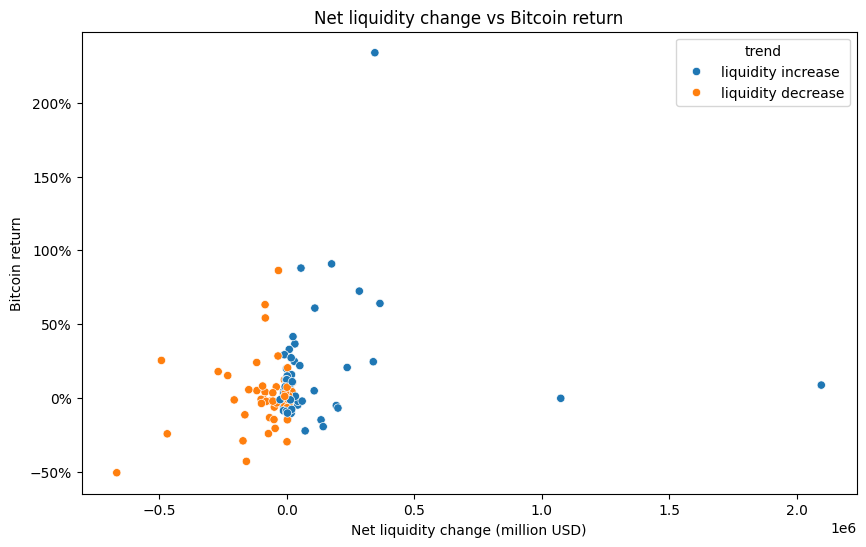

In [22]:
from matplotlib.ticker import PercentFormatter

# 创建散点图，观察流动性变化和比特币收益率之间的关系
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=liquidity_change, x="liquidity_change", y="btc_return", hue="trend", ax=ax
)
ax.set_title("Net liquidity change vs Bitcoin return")
ax.set_xlabel("Net liquidity change (million USD)")
ax.set_ylabel("Bitcoin return")
ax.yaxis.set_major_formatter(PercentFormatter(1))

In [26]:
# 准备自变量和因变量
X = liquidity_change["liquidity_change"]
y = liquidity_change["btc_return"]

# 添加常数项
X = sm.add_constant(X)

# 建立线性回归模型
model = sm.OLS(y, X)

# 拟合模型
results = model.fit()

# 模型摘要
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             btc_return   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     5.009
Date:                Mon, 27 Jan 2025   Prob (F-statistic):             0.0271
Time:                        16:28:22   Log-Likelihood:                -27.269
No. Observations:                 117   AIC:                             58.54
Df Residuals:                     115   BIC:                             64.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0811      0.029  

净流动性变化对比特币价格的影响：

- 回归模型显示，斜率系数为正，p值小于0.05，说明净流动性增加对比特币价格有正向影响。
- 从图表来看，净流动性增加对比特币价格的影响并不是一一对应的，净流动性大幅增加时，比特币价格可能小幅上涨，净流动性小幅增加时，比特币价格有可能大幅上涨。
- 当净流动性减少时，比特币价格依然有可能大幅上涨，说明净流动性并不是影响比特币价格的唯一因素。

# 流动性变化

创建柱状图来展示流动性的中期变化。

In [34]:
# 计算最近52周的流动性变化
weekly_liquidity_change = (
    df[["tga_balance", "fed_balance", "reverse_repo", "net_liquidity"]].diff().tail(52)
)
weekly_liquidity_change.tail()

,tga_balance,fed_balance,reverse_repo,net_liquidity
date,,,,
2024-12-29,-47088.0,-3369.0,170383.0,-126664.0
2025-01-05,-70124.0,-33472.0,-31362.0,68014.0
2025-01-12,-18693.0,1063.0,-58577.0,78333.0
2025-01-19,41773.0,-19484.0,-60473.0,-784.0
2025-01-26,86686.0,-2310.0,-13355.0,-75641.0


In [43]:
fig = make_subplots(
    rows=4,
    cols=1,
    shared_xaxes=True,
    subplot_titles=("TGA balance", "Fed balance", "Reverse repo", "Net liquidity"),
    vertical_spacing=0.05,
)

for i, column in enumerate(weekly_liquidity_change.columns, start=1):
    data = weekly_liquidity_change[column]
    colors = ["green" if val > 0 else "red" for val in data]
    fig.add_trace(
        go.Bar(x=data.index, y=data, marker_color=colors, name=column), row=i, col=1
    )

fig.update_layout(
    title_text="Weekly liquidity change",
    height=800,
    width=1000,
    showlegend=False,
)

fig.show()